In [1]:
from gccNMFFunctions import *
from gccNMFPlotting import *

from IPython import display

%matplotlib inline

In [2]:
# Preprocessing params
windowSize = 1024
fftSize = windowSize
hopSize = 128
windowFunction = hanning

# TDOA params
numTDOAs = 128
targetTDOAWindowSizePercent = 0.05

# NMF params
dictionarySize = 128
numIterations = 100
sparsityAlpha = 0

# Input params    
mixtureFileNamePrefix = '../data/dev_Sq1_Co_A'
microphoneSeparationInMetres = 0.086
numSources = 1

hypothesisTDOAs = getTDOAsInSeconds(microphoneSeparationInMetres, numTDOAs)
targetTDOAWindowSize = (hypothesisTDOAs[-1] - hypothesisTDOAs[0]) * targetTDOAWindowSizePercent

In [21]:
mixtureFileName = getMixtureFileName(mixtureFileNamePrefix)
stereoSamples, sampleRate = loadMixtureSignal(mixtureFileName)

numChannels, numSamples = stereoSamples.shape
durationInSeconds = numSamples / float(sampleRate)

Input mixture signal:
	sampleRate: 16000 samples/sec
	numChannels: 2
	numSamples: 160000
	dtype: float32
	duration: 10.00 seconds


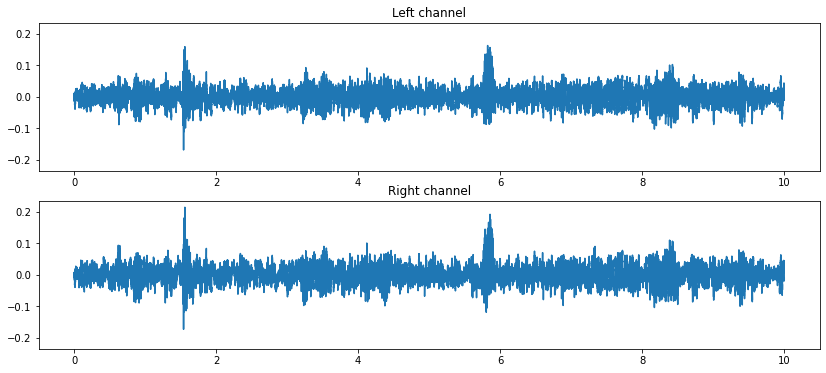

In [22]:
describeMixtureSignal(stereoSamples, sampleRate)

figure(figsize=(14, 6))
plotMixtureSignal(stereoSamples, sampleRate)

display.display( display.Audio(mixtureFileName) )

In [23]:
complexMixtureSpectrogram = computeComplexMixtureSpectrogram( stereoSamples, windowSize,
                                                              hopSize, windowFunction ) 
numChannels, numFrequencies, numTime = complexMixtureSpectrogram.shape
frequenciesInHz = getFrequenciesInHz(sampleRate, numFrequencies)
frequenciesInkHz = frequenciesInHz / 1000.0

STFT:
	windowSize: 1024
	hopSize: 128
	windowFunction: <function hanning at 0x0000027DFD181280>
	complexMixtureSpectrogram.shape = (numChannels, numFreq, numWindows): (2, 513, 1243)
	complexMixtureSpectrogram.dtype = complex64


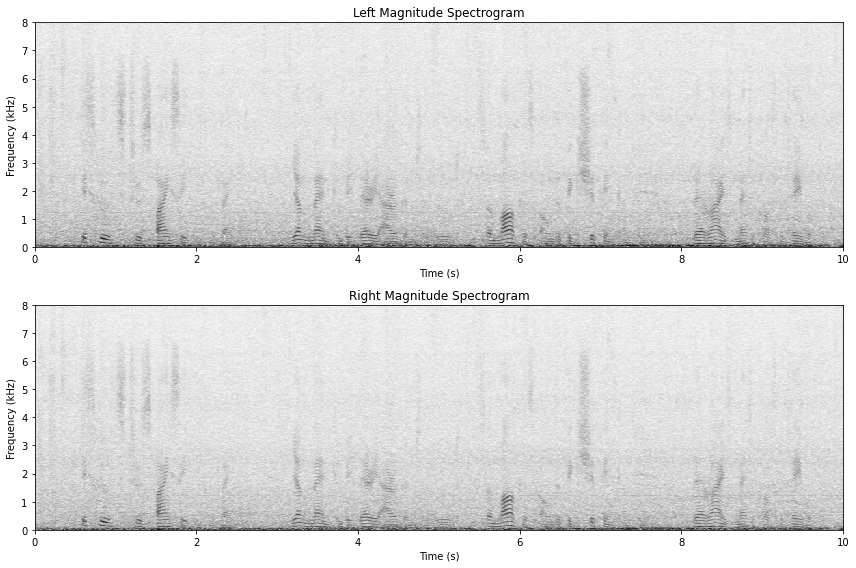

In [24]:
describeMixtureSpectrograms(windowSize, hopSize, windowFunction, complexMixtureSpectrogram)

figure(figsize=(12, 8))
plotMixtureSpectrograms(complexMixtureSpectrogram, frequenciesInkHz, durationInSeconds)

In [25]:
spectralCoherenceV = complexMixtureSpectrogram[0] * complexMixtureSpectrogram[1].conj() \
                     / abs(complexMixtureSpectrogram[0]) / abs(complexMixtureSpectrogram[1])
angularSpectrogram = getAngularSpectrogram( spectralCoherenceV, frequenciesInHz,
                                            microphoneSeparationInMetres, numTDOAs )
meanAngularSpectrum = mean(angularSpectrogram, axis=-1) 
targetTDOAIndexes = estimateTargetTDOAIndexesFromAngularSpectrum( meanAngularSpectrum,
                                                                  microphoneSeparationInMetres,
                                                                  numTDOAs, numSources)
targetTDOAIndex = targetTDOAIndexes[0]
targetTDOA = hypothesisTDOAs[targetTDOAIndex]

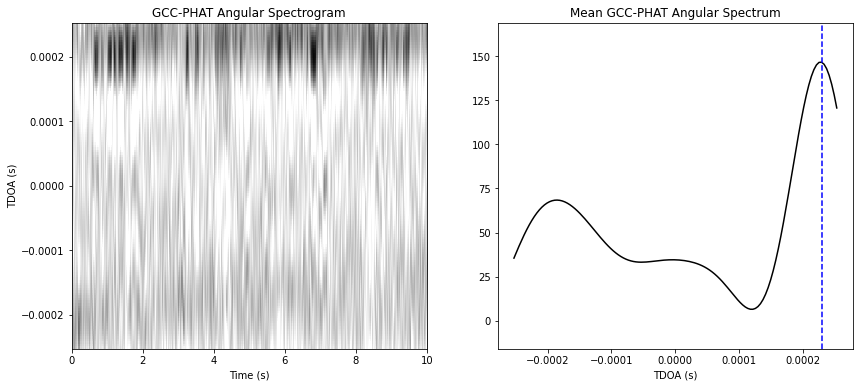

In [26]:
figure(figsize=(14, 6))
plotGCCPHATLocalization( spectralCoherenceV, angularSpectrogram, meanAngularSpectrum,
                         targetTDOAIndexes, microphoneSeparationInMetres, numTDOAs,
                         durationInSeconds )

In [27]:
V = concatenate( abs(complexMixtureSpectrogram), axis=-1 )
W, H = performKLNMF(V, dictionarySize, numIterations, sparsityAlpha)

numChannels = stereoSamples.shape[0]
stereoH = array( hsplit(H, numChannels) )

Input V:
    V.shape = (numFreq, numWindows): (513, 2486)
    V.dtype = float32
Dictionary W:
    W.shape = (numFreq, numAtoms): (513, 128)
    W.dtype = float32
Coefficients H:
    H.shape = (numAtoms, numWindows): (128, 2486)
    H.dtype = float32


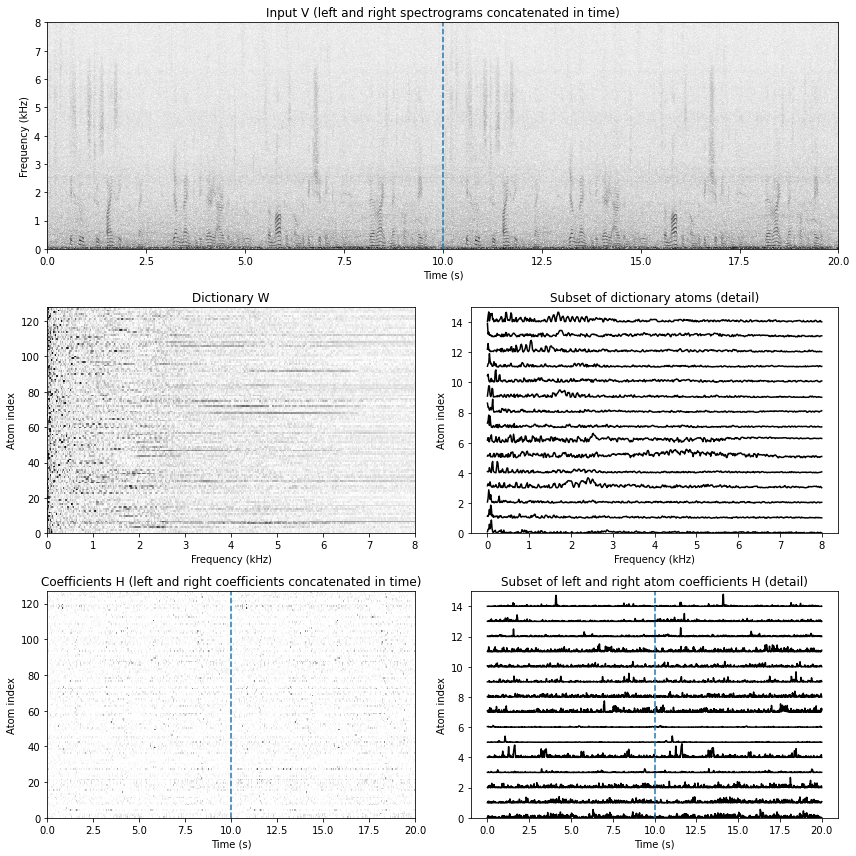

In [28]:
describeNMFDecomposition(V, W, H)

figure(figsize=(12, 12))
plotNMFDecomposition(V, W, H, frequenciesInkHz, durationInSeconds, numAtomsToPlot=15)

In [32]:
expJOmegaTau = exp( outer(frequenciesInHz, -(2j * pi) * hypothesisTDOAs) )

gccNMFs = []
for frameIndex in range(numTime):
    gccNMF = dot( (spectralCoherenceV[:, frameIndex, newaxis] * expJOmegaTau).real.T, W )
    gccNMFs.append(gccNMF)
gccNMF = array(gccNMFs).T

In [34]:
argMaxGCCNMF = argmax(gccNMF, axis=1)
gccNMFMaxTDOA = np.take(hypothesisTDOAs, argMaxGCCNMF)
distanceToTargetTDOA = abs(gccNMFMaxTDOA - targetTDOA)
targetCoefficientMask = distanceToTargetTDOA < targetTDOAWindowSize
targetCoefficientMasks = array([targetCoefficientMask])

In [35]:
figure(figsize=(16, 6))
subplot(131)
imshow( gccNMFMaxTDOA, cmap=cm.jet, extent=[0, durationInSeconds, 0, dictionarySize-1])
colorbar()
ylabel('Atom Index')
title('GCC-NMF: max TDOA')
xlabel('Time (s)')

ax = subplot(132)
imshow( distanceToTargetTDOA, cmap=cm.jet, extent=[0, durationInSeconds, 0, dictionarySize-1])
colorbar()
title('GCC-NMF Target TDOA distance')
xlabel('Time (s)')
ax.set_yticklabels([])

ax = subplot(133)
imshow(targetCoefficientMask, cmap=cm.binary, extent=[0, durationInSeconds, 0, dictionarySize-1])
colorbar()
title('GCC-NMF Coefficient Mask')
xlabel('Time (s)')
ax.set_yticklabels([])

show()

In [36]:
figure(figsize=(12, 12))
plotCoefficientMasks(targetCoefficientMasks, stereoH, durationInSeconds)

In [37]:
targetSpectrogramEstimates = getTargetSpectrogramEstimates( targetCoefficientMasks,
                                                            complexMixtureSpectrogram, W,
                                                            stereoH )

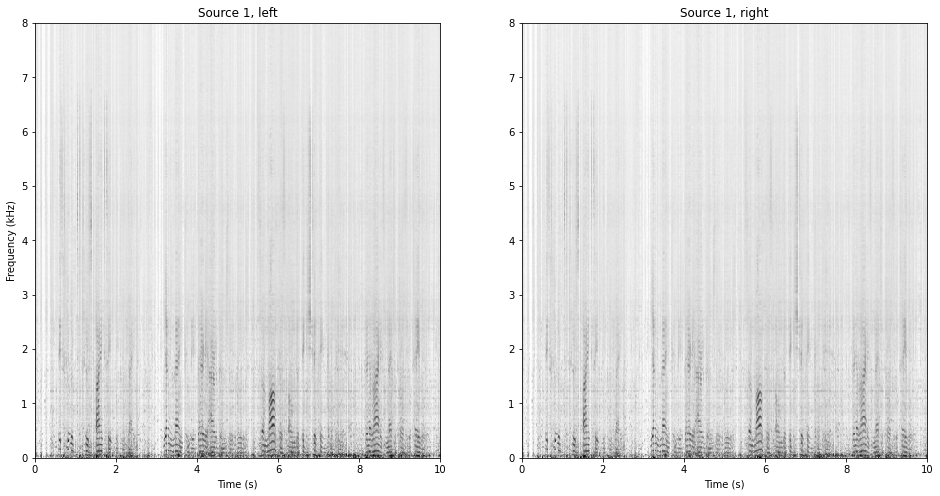

In [38]:
figure(figsize=(16, 8))
plotTargetSpectrogramEstimates(targetSpectrogramEstimates, durationInSeconds, frequenciesInkHz)

In [39]:
targetSignalEstimates = getTargetSignalEstimates( targetSpectrogramEstimates, windowSize,
                                                  hopSize, windowFunction )
saveTargetSignalEstimates(targetSignalEstimates, sampleRate, mixtureFileNamePrefix)

In [40]:
figure(figsize=(14, 2))
plotTargetSignalEstimate(stereoSamples, sampleRate, 'Input Mixture')

figure(figsize=(14, 2))
targetFileName = getSourceEstimateFileName(mixtureFileNamePrefix, 0)
plotTargetSignalEstimate( targetSignalEstimates[0], sampleRate, 'Target' )

print('Input Mixture')
display.display( display.Audio(mixtureFileName) )

print('Target Estimate')
display.display(display.Audio(targetFileName))

Input Mixture


Target Estimate
